### Import the Required Libraries

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path

### Define the Variables

In [2]:
# The grid is referred to as maze in the code.
#Define the maze size and parameters
maze_size = (100, 100)  # Size of the maze
start_pos = (1, 1)  # Start position
goal_pos = (5, 5)   # Goal position
plume_center = (3, 3)  # Center of the Gaussian plume
plume_sigma = 1.5  # Standard deviation of the Gaussian plume

action_size = 4
gamma = 0.99  # Discount factor for rewards

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

### Define the Policy Neural Network

In [3]:
# Network that outputs action probabilities and state values
class PolicyNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer_policy = nn.Linear(32, action_size)
        self.layer_value = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        value = self.layer_value(x)
        action_prob = F.softmax(self.layer_policy(x), dim = -1)

        return action_prob, value

### Generate the Grid and Define the Arrays for Action

In [4]:
# Generate the maze and Gaussian plume concentration values
maze = np.zeros(maze_size)
for x in range(maze_size[0]):
    for y in range(maze_size[1]):
        dist = np.sqrt((x - plume_center[0]) ** 2 + (y - plume_center[1]) ** 2)
        maze[x, y] = np.exp(-dist ** 2 / (2 * plume_sigma ** 2))

maze[start_pos[0], start_pos[1]] = 0  # Set start position to 0
maze[goal_pos[0], goal_pos[1]] = 1    # Set goal position to 1

policy_net = PolicyNet(maze_size[0] * maze_size[1]).to(device)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.001)

# Actions that can be taken in the maze
actions = [
    np.array([0, 1]),  # Right
    np.array([0, -1]),  # Left
    np.array([-1, 0]),  # Up
    np.array([1, 0]),  # Down
]

### Define the Policy Visualisation Function

In [5]:
# Visualise the policy
def show_policy():
    for x in range(maze_size[0]):
        for y in range(maze_size[1]):
            s = conv_to_onehot((x, y))
            action_prob, value = policy_net(s)
            a = np.argmax(action_prob.detach().cpu().numpy())

            if (x, y) == start_pos:
                print("S", end="")
            elif (x, y) == goal_pos:
                print("G", end="")
            elif a == 0:
                print("→", end="")
            elif a == 1:
                print("←", end="")
            elif a == 2:
                print("↑", end="")
            elif a == 3:
                print("↓", end="")

        print()
    print("-----------------")

# Convert coordinates in the maze to one-hot representation
def conv_to_onehot(state):
    one_hot = np.zeros(maze_size)
    one_hot[state[0], state[1]] = maze[state[0], state[1]]
    return torch.Tensor(one_hot.flatten()).to(device)

### Initialise the Performance Metric Lists and Train the Active Deep Reinforcement Learning Agent

In [6]:
init_state = start_pos     # Initial position
current_state = start_pos  # Current position

losses = []
rewards = []
accuracies = []
moving_avg_window = 10
accuracy_history = []

for i in range(100):
    current_state = init_state
    episode = []
    total_reward = 0
    correct_predictions = 0
    total_predictions = 0

    while 1:
        # Predict action
        s = conv_to_onehot(current_state)
        action_prob, state_value = policy_net(s)
        action_idx = np.random.choice(range(4), p=action_prob.detach().cpu().numpy())

        # Move
        prev_state = current_state
        current_state = current_state + actions[action_idx]

        # Check boundaries
        current_state = np.clip(current_state, [0, 0], [maze_size[0]-1, maze_size[1]-1])

        # Calculate reward
        reward = maze[current_state[0], current_state[1]]
        total_reward += reward

        # Save information
        episode.append((s, reward, action_idx, action_prob.detach()))

        # Go back to the previous state if a collision occurs
        if reward == 0:
            current_state = prev_state

        # Break if the goal is reached
        if reward == 1:
            break

    # Calculate discounted cumulative rewards
    accum_reward = 0
    rewards_list = []
    for _, r, _, _ in episode[::-1]:
        accum_reward = r + gamma * accum_reward
        rewards_list.insert(0, accum_reward)
    # Update policy
    for _ in range(5):
        # Calculate policy and value function loss
        loss_policy = 0
        loss_value = 0
        loss_entropy = 0
        for j, (s, r, a, old_action_prob) in enumerate(episode):
            action_prob, state_value = policy_net(s)
            advantage = rewards_list[j] - state_value.detach()
            eps = 0.2
            beta = 0.01
            ratio = action_prob[a] / old_action_prob[a]
            loss_policy += -torch.min(ratio * advantage, torch.clamp(ratio, 1 - eps, 1 + eps) * advantage)
            loss_value += (rewards_list[j] - state_value) ** 2
            loss_entropy += beta * torch.sum(action_prob * torch.log(action_prob + 0.000000001))
        loss = loss_policy + loss_value + loss_entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate accuracy of source estimation
    for s, _, a, _ in episode:
        action_prob, _ = policy_net(s)
        predicted_source = np.argmax(action_prob.detach().cpu().numpy())
        if predicted_source == 0 and a == 0:
            correct_predictions += 1
        if predicted_source != 0 and a != 0:
            correct_predictions += 1
        total_predictions += 1

    # Track losses, rewards, and accuracies
    losses.append(loss.item() / len(episode))
    rewards.append(total_reward)
    accuracies.append(correct_predictions / total_predictions)

    # Calculate moving average
    accuracy_history.append(correct_predictions / total_predictions)
    if len(accuracy_history) >= moving_avg_window:
        moving_avg = np.convolve(accuracy_history, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
    else:
        moving_avg = np.array(accuracy_history)

    # Visualize the policy
    if i % 10 == 0:
        # print("loss:", losses[-1])
        # print("reward:", rewards[-1])
        print("accuracy:", accuracies[-1])
        print("episode:", i)
        print("=====================================")
        # show_policy()

accuracy: 0.37623762376237624
episode: 0
accuracy: 0.7666666666666667
episode: 10
accuracy: 0.76
episode: 20
accuracy: 0.7857142857142857
episode: 30
accuracy: 0.7540983606557377
episode: 40
accuracy: 0.8
episode: 50
accuracy: 0.7419354838709677
episode: 60
accuracy: 0.6470588235294118
episode: 70
accuracy: 0.8205128205128205
episode: 80
accuracy: 0.6982758620689655
episode: 90


### Plot the Graphs to Analyse the Performance

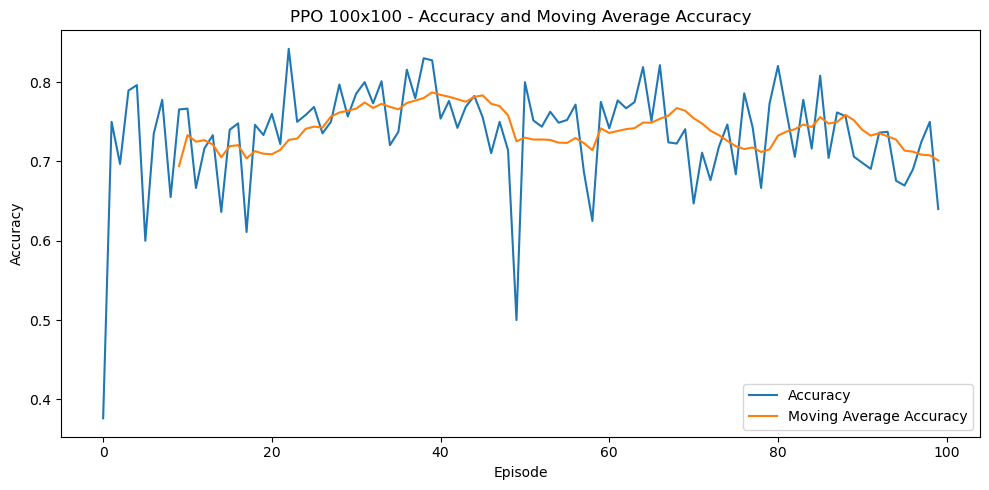

In [7]:
# Plot losses and accuracies
plt.figure(figsize=(10,5))
plt.plot(accuracies, label='Accuracy')
plt.plot(range(moving_avg_window - 1, len(moving_avg) + moving_avg_window - 1), moving_avg, label='Moving Average Accuracy')
plt.title("PPO 100x100 - Accuracy and Moving Average Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()